In [1]:
!pip install tensorflow opencv-python-headless matplotlib pillow -q

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
JSON_PATH = "/content/drive/MyDrive/SanjayBalaji/C/annotations_train_fold0.json"
IMG_SIZE = (224, 224)

In [12]:
def load_annotations_and_create_synthetic_data():
    with open(JSON_PATH, 'r') as f:
        data = json.load(f)
    print(f"Found {len(data['images'])} images in annotations")
    print(f"Found {len(data['annotations'])} annotations")
    images, labels = [], []
    img_dict = {img['id']: img for img in data['images']}
    ann_dict = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in ann_dict:
            ann_dict[img_id] = []
        ann_dict[img_id].append(ann['bbox'])
    sample_images = list(img_dict.keys())[:100]
    for img_id in sample_images:
        img_info = img_dict[img_id]
        synthetic_img = create_synthetic_wheat_image(IMG_SIZE)
        images.append(synthetic_img)
        boxes = ann_dict.get(img_id, [])[:20]
        bbox_data = []
        orig_w = img_info.get('width', 1024)
        orig_h = img_info.get('height', 1024)
        for bbox in boxes:
            x, y, bw, bh = bbox
            bbox_data.extend([x/orig_w, y/orig_h, bw/orig_w, bh/orig_h])
        bbox_data.extend([0] * (80 - len(bbox_data)))
        labels.append(bbox_data[:80])
        synthetic_img = add_wheat_heads_to_image(synthetic_img, boxes, orig_w, orig_h)
        images[-1] = synthetic_img
    return np.array(images), np.array(labels), data

In [13]:
def create_synthetic_wheat_image(size):
    img = np.random.uniform(0.3, 0.7, (*size, 3))
    noise = np.random.normal(0, 0.1, (*size, 3))
    img = np.clip(img + noise, 0, 1)
    img[:,:,0] *= 1.2
    img[:,:,1] *= 1.1
    img[:,:,2] *= 0.8
    img = np.clip(img, 0, 1)
    return img

In [14]:
def add_wheat_heads_to_image(img, bboxes, orig_w, orig_h):
    h, w = img.shape[:2]
    for bbox in bboxes:
        x, y, bw, bh = bbox
        x = int(x * w / orig_w)
        y = int(y * h / orig_h)
        bw = int(bw * w / orig_w)
        bh = int(bh * h / orig_h)
        center_x, center_y = x + bw//2, y + bh//2
        for dy in range(-bh//2, bh//2):
            for dx in range(-bw//2, bw//2):
                if (dx*dx)/(bw*bw/4) + (dy*dy)/(bh*bh/4) <= 1:
                    px, py = center_x + dx, center_y + dy
                    if 0 <= px < w and 0 <= py < h:
                        img[py, px] = [0.9, 0.8, 0.4]

    return img

In [15]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(80, activation='sigmoid')
    ])
    return model

In [16]:
def visualize_synthetic_data(images, labels, n=3):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axes = [axes]
    for i in range(min(n, len(images))):
        axes[i].imshow(images[i])
        bbox_data = labels[i].reshape(-1, 4)
        box_count = 0
        for bbox in bbox_data:
            if bbox.sum() > 0:
                x, y, w, h = bbox * np.array([*IMG_SIZE, *IMG_SIZE])
                rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
                axes[i].add_patch(rect)
                box_count += 1
        axes[i].set_title(f'Synthetic Image {i+1}\nWheat heads: {box_count}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [17]:
print("Loading annotations and creating synthetic wheat data...")
X, y, annotation_data = load_annotations_and_create_synthetic_data()
print(f"Created {len(X)} synthetic images with real annotation data")

Loading annotations and creating synthetic wheat data...
Found 4573 images in annotations
Found 158597 annotations
Created 100 synthetic images with real annotation data



Visualization of synthetic wheat field images:


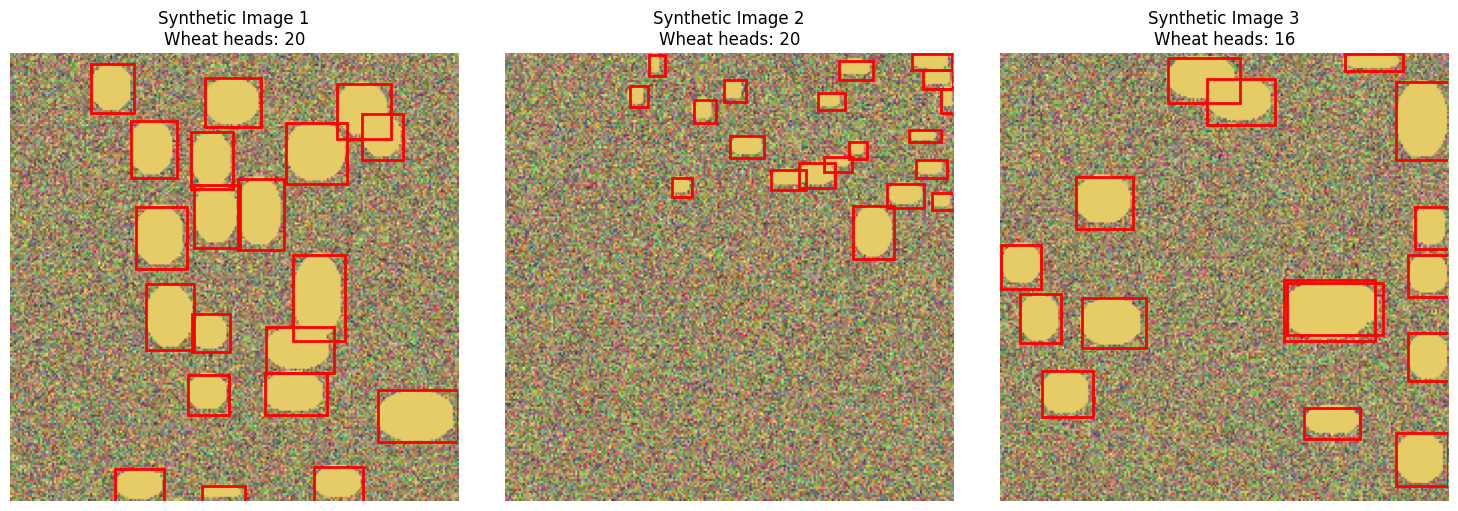

In [18]:
print("\nVisualization of synthetic wheat field images:")
visualize_synthetic_data(X, y, 3)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = create_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(f"\nModel created. Training samples: {len(X_train)}, Test samples: {len(X_test)}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model created. Training samples: 80, Test samples: 20


In [21]:
print("\nStarting training on synthetic data...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=8,
    verbose=1
)


Starting training on synthetic data...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.1289 - mae: 0.3316 - val_loss: 0.0539 - val_mae: 0.1594
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 841ms/step - loss: 0.0609 - mae: 0.1691 - val_loss: 0.0427 - val_mae: 0.1395
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 901ms/step - loss: 0.0502 - mae: 0.1588 - val_loss: 0.0428 - val_mae: 0.1444
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0522 - mae: 0.1594 - val_loss: 0.0436 - val_mae: 0.1358
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 871ms/step - loss: 0.0476 - mae: 0.1507 - val_loss: 0.0424 - val_mae: 0.1360
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0482 - mae: 0.1507 - val_loss: 0.0420 - val_mae: 0.1389
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 922ms/step - loss: 0.0467 - mae: 0.1502 - val_loss: 0.0420 - val_mae: 0.1344
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 862ms/step - loss: 0.0483 - mae: 0.1503 - val_loss: 0.0423 - val_mae: 0.1367
Epoch 9/10
10/10 ━━

Text(0.5, 1.0, 'Training Loss')

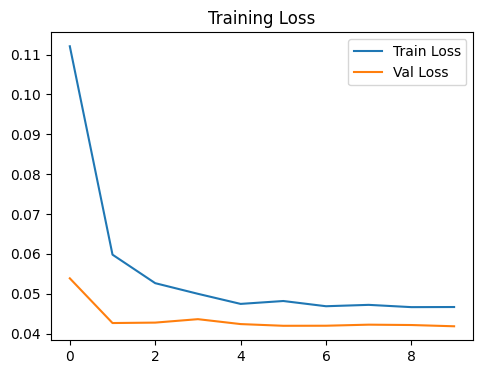

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training Loss')

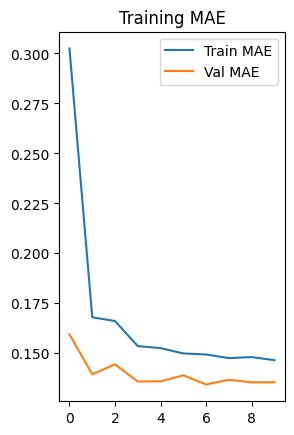

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Training MAE')
plt.show()

In [24]:
predictions = model.predict(X_test[:3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


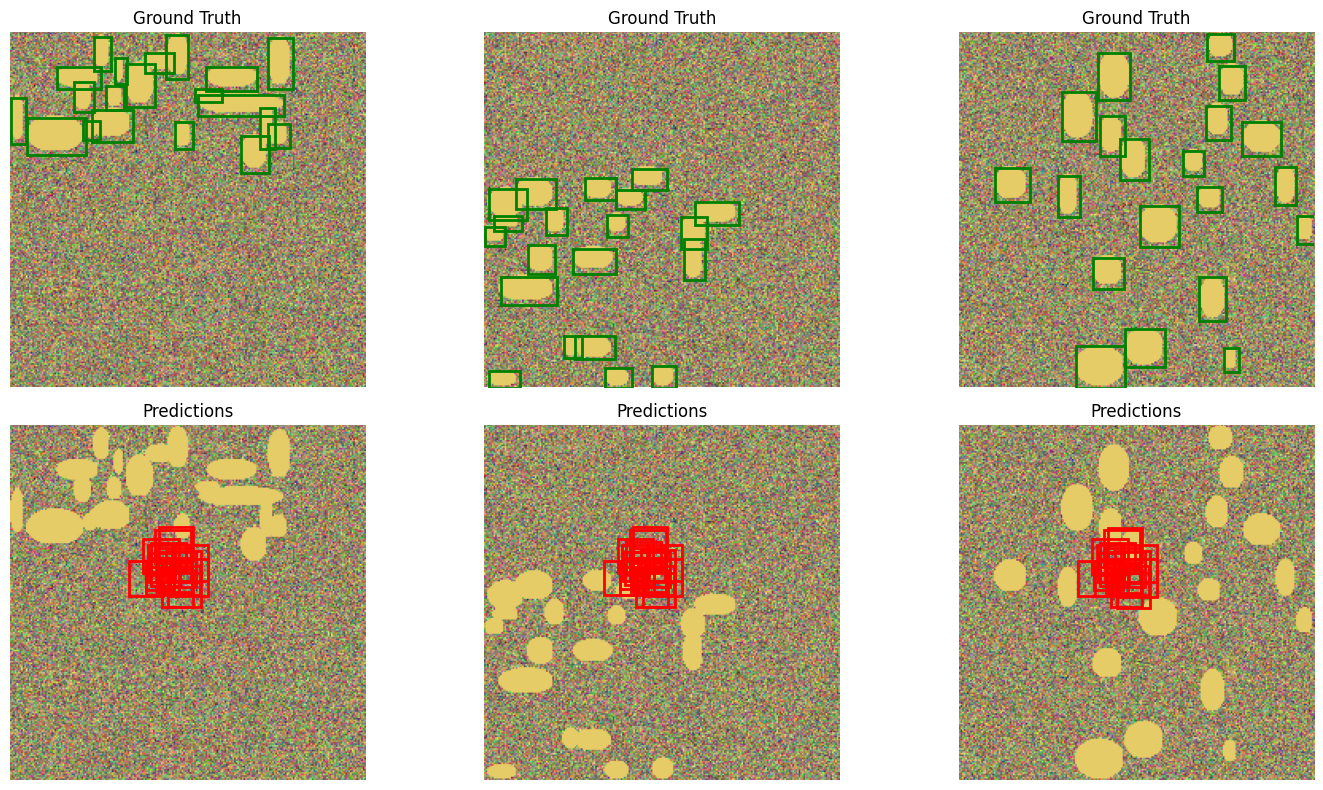

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(3):
    axes[0, i].imshow(X_test[i])
    axes[0, i].set_title('Ground Truth')
    true_bbox = y_test[i].reshape(-1, 4)
    for bbox in true_bbox:
        if bbox.sum() > 0:
            x, y, w, h = bbox * np.array([*IMG_SIZE, *IMG_SIZE])
            rect = plt.Rectangle((x, y), w, h, fill=False, color='green', linewidth=2)
            axes[0, i].add_patch(rect)
    axes[1, i].imshow(X_test[i])
    axes[1, i].set_title('Predictions')
    pred_bbox = predictions[i].reshape(-1, 4)
    for bbox in pred_bbox:
        if bbox.sum() > 0.1:  # Threshold
            x, y, w, h = bbox * np.array([*IMG_SIZE, *IMG_SIZE])
            rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
            axes[1, i].add_patch(rect)
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [29]:
model.save('wheat_detection_demo_model.h5')
print(f"\nDemo completed! Model saved.")
print(f"This demo used synthetic images with real annotation coordinates from your JSON file.")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")


Demo completed! Model saved.
This demo used synthetic images with real annotation coordinates from your JSON file.
Final validation loss: 0.0418
